In [1]:
#

import xbbg
import scipy
from scipy.interpolate import CubicSpline
from xbbg import blp
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.pyplot import plot
from matplotlib import pyplot as plt
import os
import matplotlib.ticker as plticker
import pandas_datareader as pdr
import matplotlib.ticker as mticker
#data
#load portfolio tickers
port_df = pd.read_csv('equity_names.csv', index_col = None)

#SBL data
sbl_data = pd.read_csv('stock_borrow_data.csv', index_col = None)
sbl_data['Date']= pd.to_datetime(sbl_data['Date'])
tickers = sbl_data['BBG Ticker'].unique()
#bbg data
start_date = datetime.today()- \
                        relativedelta(days = 365*5) #datetime.strptime(df.index[-10],'%d/%m/%Y')
#set end date (t)
end_date = datetime.today()
data_bbg = pd.DataFrame()
for ticker in tickers:
    data = blp.bdh(tickers=ticker
             , flds=['SHORT_INT',
                    'PX_LAST',
                    'PX_VOLUME',
                    'VOLUME_AVG_10D',
                    'VOLUME_AVG_30D',
                    'VOLUME_AVG_60D',
                    'VOLATILITY_10D',
                    'VOLATILITY_30D',
                    'VOLATILITY_60D',
                    'CALL_IMP_VOL_10D',
                    'CALL_IMP_VOL_30D',
                    'CALL_IMP_VOL_60D',
                    'VOLUME_TOTAL_CALL',
                    'OPEN_INT_TOTAL_CALL',
                    'VOLUME_TOTAL_PUT',
                    'OPEN_INT_TOTAL_PUT',
                    'PUT_CALL_OPEN_INTEREST_RATIO',
                    'PUT_CALL_OPEN_INTEREST_TOTAL'
                        ],
             start_date= start_date, end_date=end_date,Per='D')
    data.index.names = ['date']
    data.index = data.index#.strftime('%d/%m/%Y')
    data.columns = data.columns.droplevel(0)
    data['VOLUME_AVG_10D'] = data['PX_VOLUME'].rolling(window=10).mean()
    data['VOLUME_AVG_30D'] = data['PX_VOLUME'].rolling(window=30).mean()
    data['VOLUME_AVG_60D'] = data['PX_VOLUME'].rolling(window=60).mean()
    data['Ticker'] = ticker
    
    data_bbg = pd.concat([data_bbg,data])  
data_bbg.reset_index(inplace = True) 
data_bbg['date']= pd.to_datetime(data_bbg['date'])
#join stock_borrow_data data
data_market = pd.merge(data_bbg,sbl_data, left_on = ['date','Ticker'], right_on = ['Date','BBG Ticker'])
data_market['Shares on Loan']= data_market['Shares on Loan'].str.replace(',','').astype(float)
data_market['Available Inventory']= data_market['Available Inventory'].str.replace(',','').astype(float)


In [3]:
tickers

array(['ARM US Equity', 'TLRY US Equity', 'BYND US Equity',
       'DJT US Equity', 'CART US Equity', 'AI US Equity', 'ZIM US Equity',
       'TSLA US Equity', 'GME US Equity', 'MARA US Equity'], dtype=object)

In [2]:
regress_df['Available Inventory']

NameError: name 'regress_df' is not defined

In [3]:
regress_df= data_market[data_market['Ticker']=='ARM US Equity']
regress_df['SHORT_INT'].ffill(inplace = True)
regress_df['PX_CHANGE_PCT'] = regress_df['PX_LAST'].diff()/regress_df['PX_LAST'] 
regress_df['shsonloan_availableinventory'] = regress_df['Shares on Loan']/regress_df['Available Inventory']
#Set Y the output variable as the shifted PX_change (1 day back) as we need to predict the fwd data

 
regress_df['PX_CHANGE_PCT_SHIFT'] = regress_df['PX_CHANGE_PCT'].shift(-1)

regress_df.dropna(inplace = True) 
Y = regress_df['PX_CHANGE_PCT_SHIFT']
X_input = regress_df[['VOLUME_TOTAL_CALL',
                      'OPEN_INT_TOTAL_CALL',
                      'VOLUME_TOTAL_PUT',
                      'OPEN_INT_TOTAL_PUT',
                      'PUT_CALL_OPEN_INTEREST_RATIO',
                      'VOLUME_AVG_10D',
                      'VOLUME_AVG_30D',
                      'VOLUME_AVG_60D',
                      'Utilization',
                      'Available Inventory',
                      'shsonloan_availableinventory',
                      '# of Loan Contracts']]
                      

correlation_matrix = X_input.corr()

C:\Users\chengc3\AppData\Local\Temp\ipykernel_35560\2597025166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regress_df['SHORT_INT'].ffill(inplace = True)
C:\Users\chengc3\AppData\Local\Temp\ipykernel_35560\2597025166.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regress_df['PX_CHANGE_PCT'] = regress_df['PX_LAST'].diff()/regress_df['PX_LAST']
C:\Users\chengc3\AppData\Local\Temp\ipykernel_35560\2597025166.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [4]:
correlation_matrix

,VOLUME_TOTAL_CALL,OPEN_INT_TOTAL_CALL,VOLUME_TOTAL_PUT,OPEN_INT_TOTAL_PUT,PUT_CALL_OPEN_INTEREST_RATIO,VOLUME_AVG_10D,VOLUME_AVG_30D,VOLUME_AVG_60D,Utilization,Available Inventory,shsonloan_availableinventory,# of Loan Contracts
VOLUME_TOTAL_CALL,1.000000,0.495225,0.884964,0.521066,-0.106701,0.608117,0.376989,0.197170,0.125929,-0.155811,0.201747,-0.054392
OPEN_INT_TOTAL_CALL,0.495225,1.000000,0.508710,0.970144,-0.256671,0.557755,0.817366,0.841486,-0.356715,-0.792210,-0.223178,-0.673561
VOLUME_TOTAL_PUT,0.884964,0.508710,1.000000,0.547517,-0.079362,0.471460,0.321697,0.306560,-0.062172,-0.280995,0.020068,-0.187308
OPEN_INT_TOTAL_PUT,0.521066,0.970144,0.547517,1.000000,-0.057443,0.565586,0.810244,0.875636,-0.401767,-0.830125,-0.272876,-0.732771
PUT_CALL_OPEN_INTEREST_RATIO,-0.106701,-0.256671,-0.079362,-0.057443,1.000000,-0.000742,-0.058461,0.016770,-0.088896,-0.023234,-0.135539,-0.175851
VOLUME_AVG_10D,0.608117,0.557755,0.471460,0.565586,-0.000742,1.000000,0.568711,0.280006,0.187104,-0.234669,0.296524,-0.134610
VOLUME_AVG_30D,0.376989,0.817366,0.321697,0.810244,-0.058461,0.568711,1.000000,0.632559,0.027441,-0.556331,0.142066,-0.452332
VOLUME_AVG_60D,0.197170,0.841486,0.306560,0.875636,0.016770,0.280006,0.632559,1.000000,-0.732447,-0.983381,-0.637744,-0.946549
Utilization,0.125929,-0.356715,-0.062172,-0.401767,-0.088896,0.187104,0.027441,-0.732447,1.000000,0.784344,0.982803,0.846022
Available Inventory,-0.155811,-0.792210,-0.280995,-0.830125,-0.023234,-0.234669,-0.556331,-0.983381,0.784344,1.000000,0.690401,0.951389


In [20]:
#Basic multivariate iniear regression
import statsmodels.api as sm
X_input = sm.add_constant(X_input)

#fit the model
regression_model =sm.OLS(Y,X_input)
results = regression_model.fit()
predictions = results.predict(np.array(X_input))
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     PX_CHANGE_PCT_SHIFT   R-squared:                       0.185
Model:                             OLS   Adj. R-squared:                  0.068
Method:                  Least Squares   F-statistic:                     1.584
Date:                 Thu, 16 May 2024   Prob (F-statistic):              0.112
Time:                         13:54:36   Log-Likelihood:                 140.02
No. Observations:                   97   AIC:                            -254.0
Df Residuals:                       84   BIC:                            -220.6
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const 

In [27]:
Y.reset_index()

,index,PX_CHANGE_PCT_SHIFT
0,57,0.071248
1,58,-0.036061
2,59,-0.002782
3,60,0.013717
4,61,0.072454
...,...,...
92,152,0.039431
93,153,0.012495
94,154,-0.020057
95,155,-0.062126


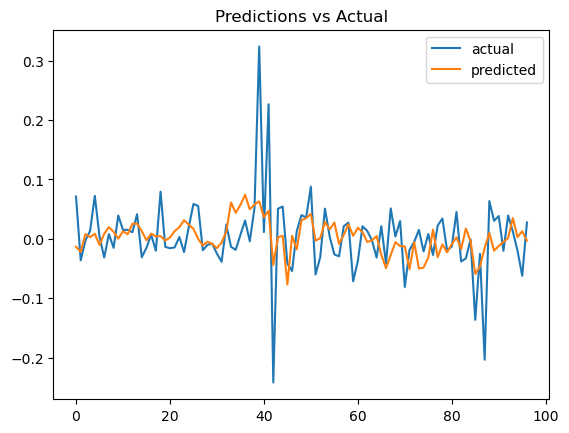

In [31]:
plt.plot(Y.reset_index()['PX_CHANGE_PCT_SHIFT'], label = 'actual')
plt.plot(predictions, label = 'predicted')
plt.title('Predictions vs Actual')
plt.legend()

In [32]:
#Try principal component regression (PCR)
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

pca = PCA()
X_pca = pca.fit_transform(X_input)

#determine the number of components to use
#use explained variance ratio to decide
#choose compoents that explain 95% of the variance

total_variance = np.sum(pca.explained_variance_ratio_)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >=0.95)+1

#Create PCR model with the number of components

model = make_pipeline(PCA(n_components = num_components), LinearRegression())

#fit the model
model.fit(X_input,Y)
predictions = model.predict(X_input)

#r-squared
r_squared = r2_score(Y, predictions)
print("R-squared: ", r_squared)

#residuals and p_values
residuals = Y - predictions

#step 6: fit a multiple linear regression model with original variables and residuals
X_with_residuals = np.column_stack((X_input,residuals))
X_with_residuals = sm.add_constant(X_with_residuals)
model_with_residuals = sm.OLS(Y, X_with_residuals).fit()
p_values = model_with_residuals.pvalues
print("P-values:", p_values)

R-squared:  0.027362211069725362
P-values: const    0.000000e+00
x1       0.000000e+00
x2       0.000000e+00
x3       0.000000e+00
x4       0.000000e+00
x5       9.991319e-01
x6       0.000000e+00
x7       0.000000e+00
x8       0.000000e+00
x9       9.998444e-01
x10      0.000000e+00
x11      9.994068e-01
x12      6.486300e-58
x13      0.000000e+00
dtype: float64


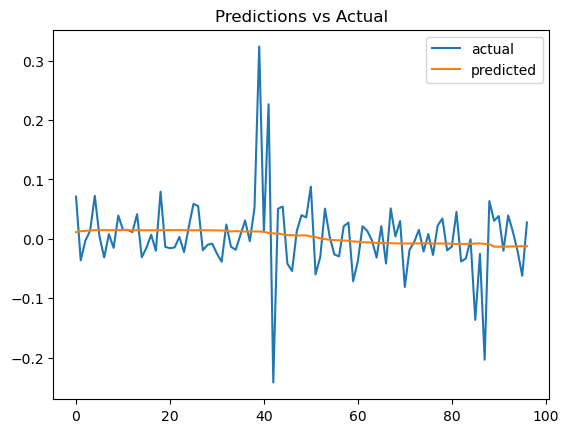

In [36]:
plt.plot(Y.reset_index()['PX_CHANGE_PCT_SHIFT'], label = 'actual')
plt.plot(predictions, label = 'predicted')
plt.title('Predictions vs Actual')
plt.legend()

In [33]:
r_squared = r2_score(Y, predictions)

In [34]:
regress_df

,date,SHORT_INT,PX_LAST,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,VOLATILITY_60D,CALL_IMP_VOL_10D,CALL_IMP_VOL_30D,CALL_IMP_VOL_60D,...,Avg Fee (exclusive of FF),New Fee (exclusive of FF),Returned Shares,Avg Age of Returned Loans,Returned %,Age Return Ratio,# of Loan Contracts,PX_CHANGE_PCT,shsonloan_availableinventory,PX_CHANGE_PCT_SHIFT
57,2023-12-07,13134955.0,62.44,3139112.0,50.160,50.038,53.560,43.118,43.515,47.464,...,0.8681,9.7426,"1,067,500",5.9896,0.029729,0.216835,588,0.022101,1.183577,0.071248
58,2023-12-08,13134955.0,67.23,18815931.0,57.247,52.951,54.886,46.876,45.971,48.582,...,0.9097,1.4215,"865,515",5.8724,0.023715,0.209589,579,0.071248,1.202101,-0.036061
59,2023-12-11,13134955.0,64.89,7625495.0,62.245,53.721,54.505,44.206,45.810,49.038,...,0.8907,2.2449,"442,122",13.1317,0.012023,0.428410,592,-0.036061,1.213511,-0.002782
60,2023-12-12,13134955.0,64.71,5711703.0,62.395,53.559,53.378,42.201,44.054,48.781,...,1.0110,2.7869,"550,163",18.5153,0.014184,0.619268,631,-0.002782,1.267732,0.013717
61,2023-12-13,13134955.0,65.61,7023954.0,61.784,53.370,52.569,43.002,44.310,48.395,...,1.0769,2.7860,"1,081,739",3.4026,0.027958,0.110133,655,0.013717,1.252897,0.072454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,2024-04-25,8370719.0,97.93,6140842.0,130.308,84.728,131.704,74.901,78.126,65.793,...,0.2004,0.2389,"805,500",10.5890,0.199622,0.432393,135,-0.019912,0.381569,0.039431
153,2024-04-26,8370719.0,101.95,5651662.0,135.319,85.769,131.893,79.983,74.709,65.567,...,0.1905,0.1509,"904,670",8.0942,0.190408,0.402570,135,0.039431,0.440773,0.012495
154,2024-04-29,8370719.0,103.24,4009208.0,136.133,85.525,131.900,90.738,74.518,64.374,...,0.1901,0.1485,"177,162",5.0313,0.033040,0.246887,140,0.012495,0.488114,-0.020057
155,2024-04-30,7692422.0,101.21,3783680.0,119.370,85.013,131.902,99.135,76.594,65.320,...,0.1901,0.1500,"443,015",9.2324,0.084237,0.427353,146,-0.020057,0.465279,-0.062126
